# Image Classification

## Importing Libraries

In [1]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from dataclasses import dataclass
import platform

# Text formatting
bold = "\033[1m"
end = "\033[0m"

block_plot=False

%matplotlib inline

In [2]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

set_seeds()

## Data Preparation 

In [3]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your CSV file
df = pd.read_csv('/kaggle/input/open-cv-tf-project-2-image-classification-round-3/train.csv')

# Define paths
image_folder = '/kaggle/input/open-cv-tf-project-2-image-classification-round-3/sports_images/all_images'
train_folder = '/kaggle/working/train'
valid_folder = '/kaggle/working/valid'

# Create directories for training and validation
os.makedirs(train_folder, exist_ok=True)
os.makedirs(valid_folder, exist_ok=True)

# Define the split ratio
train_ratio = 0.8

# Get unique class labels
class_labels = df['CLASS'].unique()

# Create directories for each class in train and valid folders
for label in class_labels:
    os.makedirs(os.path.join(train_folder, label), exist_ok=True)
    os.makedirs(os.path.join(valid_folder, label), exist_ok=True)

# Split data into training and validation sets
train_df, valid_df = train_test_split(df, test_size=1-train_ratio, random_state=42)

# Move images to their respective directories
def move_images(df, target_folder):
    for _, row in df.iterrows():
        image_file = row['ID']
        class_label = row['CLASS']
        
        src = os.path.join(image_folder, image_file)
        dst = os.path.join(target_folder, class_label, image_file)
        
        shutil.copy(src, dst)

# Move images for training and validation
move_images(train_df, train_folder)
move_images(valid_df, valid_folder)

print("Data split and organized successfully!")


Data split and organized successfully!


In [4]:
# If required, update the root_dir path according to the dataset path.

root_dir = '/kaggle/working/'

train_dir = os.path.join(root_dir, "train")
valid_dir = os.path.join(root_dir, "valid")

In [5]:
def list_folders(startpath):
    for root, _, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root):<8}')


list_folders(root_dir)

        
valid   
    rock_climbing
    bmx     
    giant_slalom
    harness_racing
    uneven_bars
    football
    surfing 
    snow_boarding
    nascar_racing
    pole_vault
    sailboat_racing
    formula_1_racing
    rings   
    horse_racing
    bobsled 
    pommel_horse
    baseball
    cricket 
    luge    
    curling 
    bull_riding
    figure_skating_men
    ski_jumping
    ampute_football
    canoe_slamon
    javelin 
    fencing 
    water_polo
    hammer_throw
    tennis  
    rugby   
    polo    
    rollerblade_racing
    ice_climbing
    hurdles 
    motorcycle_racing
    balance_beam
    tug_of_war
    field_hockey
    lacrosse
    judo    
    bowling 
    figure_skating_women
    high_jump
    snowmobile_racing
    arm_wrestling
    golf    
    sumo_wrestling
    croquet 
    jai_alai
    wheelchair_basketball
    archery 
    wheelchair_racing
    figure_skating_pairs
    air_hockey
    speed_skating
    shot_put
    weightlifting
    frisbee 
    basketball
  

In [6]:
print(f"{bold}Training Classes:{end} ")
for i in os.listdir(train_dir):
    print(i)
    
print("------------")

print(f"{bold}Validation Classes:{end} ")
for j in os.listdir(valid_dir):
    print(j)

Training Classes: 
rock_climbing
bmx
giant_slalom
harness_racing
uneven_bars
football
surfing
snow_boarding
nascar_racing
pole_vault
sailboat_racing
formula_1_racing
rings
horse_racing
bobsled
pommel_horse
baseball
cricket
luge
curling
bull_riding
figure_skating_men
ski_jumping
ampute_football
canoe_slamon
javelin
fencing
water_polo
hammer_throw
tennis
rugby
polo
rollerblade_racing
ice_climbing
hurdles
motorcycle_racing
balance_beam
tug_of_war
field_hockey
lacrosse
judo
bowling
figure_skating_women
high_jump
snowmobile_racing
arm_wrestling
golf
sumo_wrestling
croquet
jai_alai
wheelchair_basketball
archery
wheelchair_racing
figure_skating_pairs
air_hockey
speed_skating
shot_put
weightlifting
frisbee
basketball
billiards
rowing
hockey
table_tennis
track_bicycle
boxing
olympic_wrestling
horse_jumping
barell_racing
volleyball
swimming
skydiving
parallel_bar
------------
Validation Classes: 
rock_climbing
bmx
giant_slalom
harness_racing
uneven_bars
football
surfing
snow_boarding
nascar_raci

In [7]:
num_train_files = 0
num_valid_files = 0



def count_files_in_directory(directory):
    total_files = 0
    for root, _, files in os.walk(directory):
        total_files += len(files)
    return total_files

num_train_files = count_files_in_directory(train_dir)
num_valid_files = count_files_in_directory(valid_dir)



print(f"{bold}Number of Training samples: {end}{num_train_files}")
print(f"{bold}Number of Validation samples: {end}{num_valid_files}")

Number of Training samples: 8024
Number of Validation samples: 2007


Image size: (224, 224, 3), target: weightlifting


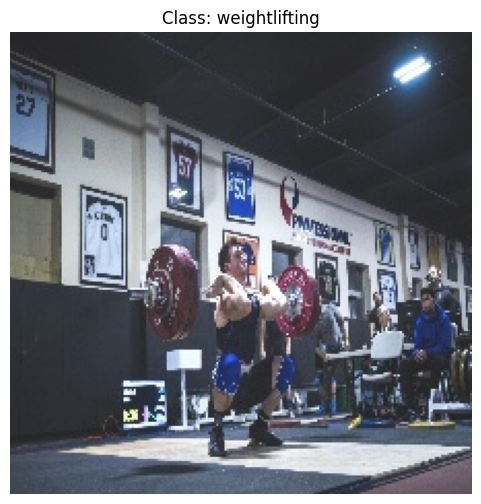

In [8]:
target = "weightlifting"

# Load image and print its shape/size.


class_dir = os.path.join(train_dir, target)

image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
sample_image_file = random.choice(image_files)
sample_image_path = os.path.join(class_dir, sample_image_file)

with Image.open(sample_image_path) as img:
    width, height = img.size

    if img.mode == 'RGB':
        channels = 3
    elif img.mode == 'L':
        channels = 1
    else:
        channels = len(img.getbands())

    print(f"Image size: ({height}, {width}, {channels}), target: {target}")


    # Display the image
    plt.figure(figsize=(6, 6))
    plt.title(f"Class: {target}")
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()


In [9]:
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, RandomContrast, RandomBrightness

def data_augmentation_preprocess(seed=None):
    if seed is not None:
        tf.random.set_seed(seed)

    rand_rotation = RandomRotation(0.15, fill_mode='nearest', seed=seed)
    rand_flip_hor = RandomFlip("horizontal", seed=seed)
    rand_zoom = RandomZoom(height_factor=(-.5, .5), width_factor=(-.5, .5), fill_mode='nearest', seed=seed)
    rand_contrast = RandomContrast(factor=0.2, seed=seed)
    rand_brightness = RandomBrightness(factor=0.2, seed=seed)

    data_augmentation_pipeline = tf.keras.Sequential([
        rand_rotation,
        rand_flip_hor,
        rand_zoom,
        rand_contrast,
        rand_brightness,
    ])

    return data_augmentation_pipeline


In [10]:
def get_data(*, data_root, target_size=(224, 224), batch_size=32, data_augmentation=False):
    
    train_path = os.path.join(data_root, "train")
    train_dataset = image_dataset_from_directory(
        train_path, 
        label_mode='categorical',
        color_mode='rgb', 
        batch_size=batch_size, 
        image_size=target_size, 
        shuffle=True,
    )

    valid_path = os.path.join(data_root, "valid")    
    valid_dataset = image_dataset_from_directory(
        valid_path, 
        label_mode='categorical',
        color_mode='rgb', 
        batch_size=batch_size, 
        image_size=target_size, 
        shuffle=False, 
    )
    
    if data_augmentation: 
        data_augmentation_pipeline = data_augmentation_preprocess()
        train_dataset = train_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))
         
            
        
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)    
    valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE) # Corrected this line
    
    return train_dataset, valid_dataset

## Configuration 


In [11]:
@dataclass
class TrainingConfig:    
    BATCH_SIZE: int = 32
    EPOCHS: int = 90
    LEARNING_RATE: float = 0.001

    # For tensorboard logging and saving checkpoints
    root_log_dir = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_initial = "version_0"


In [12]:
@dataclass
class DatasetConfig:
    DATA_ROOT: str = "/kaggle/working/"
    DATA_SHAPE: tuple = (224, 224, 3)
    NUM_CLASSES: int = 73

In [13]:
def get_callbacks(
    training_config=TrainingConfig(),
    monitor="accuracy",
    mode="max",
    save_weights_only=False,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=training_config.log_dir,
        histogram_freq=20,
        write_graph=True,
        update_freq="epoch",
        write_images=True,
    )

    
    checkpoint_filepath = training_config.checkpoint_path
    
    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = os.path.join(checkpoint_filepath, "model.ckpt")
    else:
        checkpoint_filepath = os.path.join(checkpoint_filepath, "model.keras")

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=0,
    )
    
    return [tensorboard_callback, model_checkpoint_callback]

In [14]:
def setup_log_directory(training_config=TrainingConfig()):
    '''Tensorboard Log, Model checkpoint directory Setup and Early stopping'''
    
    get_number = lambda path: path.replace(".keras", "").replace("version_", "")
    
    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        folder_numbers = [int(get_number(folder)) for folder in os.listdir(training_config.root_log_dir)]
        
        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir


    # Update the training config default directory 
    training_config.log_dir        = os.path.join(training_config.root_log_dir,        version_name)
    training_config.checkpoint_path = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version
    os.makedirs(training_config.log_dir, exist_ok=True)
    os.makedirs(training_config.root_checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_path}")
    
    return training_config, version_name

In [15]:
def plot_history(
    train_loss=None,
    val_loss=None,
    train_metric=None,
    val_metric=None,
    colors=["blue", "green"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(15, 10),
):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    fig.set_facecolor("white")

    # Loss Plots
    plt.subplot(2, 1, 1)

    train_loss_range = range(len(train_loss))
    plt.plot(
        train_loss_range,
        train_loss,
        color=f"tab:{colors[0]}",
        label=f"Train Loss",
    )

    valid_loss_range = range(len(val_loss))
    plt.plot(
        valid_loss_range,
        val_loss,
        color=f"tab:{colors[1]}",
        label=f"Valid Loss",
    )

    plt.ylabel("Loss")
    plt.legend(loc=loss_legend_loc)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.title("Training and Validation Loss")

    # Mean Average Precision Plots
    plt.subplot(2, 1, 2)

    train_metric_range = range(len(train_metric))
    plt.plot(
        train_metric_range,
        train_metric,
        color=f"tab:{colors[0]}",
        label=f"Train Accuracy",
    )

    val_metric_range = range(len(val_metric))
    plt.plot(
        val_metric_range,
        val_metric,
        color=f"tab:{colors[1]}",
        label=f"Valid Accuracy",
    )

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc=acc_legend_loc)
    plt.grid(True)
    plt.title("Training and Validation Accuracy")

    plt.show(block=block_plot)

    return

# Model


In [16]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

def get_simplified_model(num_classes, input_shape):
    # Load the pre-trained EfficientNetB0 model without the top classification layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    
    base_model.trainable = False

    # Create the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Global pooling layer instead of flattening
        layers.Dense(1024, activation='relu'),  # Dense layer for extra learning power
        layers.Dropout(0.5),  # Dropout for regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer for class probabilities
    ])

    return model

In [17]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

### Model Training
def train_model(
    dataset_config,
    training_config,
    data_augmentation=True,
    print_summary=True,
    version_number=None,
):
    # Get training and validation datasets
    train_dataset, valid_dataset = get_data(
        data_root=dataset_config.DATA_ROOT,
        target_size=dataset_config.DATA_SHAPE[:2],
        batch_size=training_config.BATCH_SIZE,
        data_augmentation=data_augmentation,
    )
    
    for images, labels in valid_dataset:
        print("X Shape:", images.shape, "Y Shape:", labels.shape)
        break

    # Version control
    if version_number is None:
        os.makedirs(training_config.root_log_dir, exist_ok=True)
        os.makedirs(training_config.root_checkpoint_dir, exist_ok=True)
        
        folders = os.listdir(training_config.root_log_dir)
        
        if len(folders):
            last_version_number = int(sorted(folders)[-1].replace("version_", ""))
            version_number = last_version_number + 1
        else:
            version_number = 1

    log_dir = os.path.join(training_config.root_log_dir, f"version_{version_number}")
    checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, f"version_{version_number}")

    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"Logging at: {log_dir}")

    # Get model
    model = get_simplified_model(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)

    # Compile model
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
        metrics=["accuracy"],
    )

    # Print model summary
    if print_summary:
        model.summary()

    # Callbacks
    tensorboard_callback = TensorBoard(log_dir=log_dir, update_freq="epoch")
    model_checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "best_model.keras"),
        save_weights_only=False,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True
    )
    #early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks = [tensorboard_callback, model_checkpoint_callback]

    # Train model
    training_results = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=training_config.EPOCHS,
        callbacks=callbacks,
    )

    print("training_results keys:", training_results.history.keys())

    return model, training_results

In [18]:
training_config = TrainingConfig()

# Tensorboard Log and model checkpoint Setup.
training_config, current_version_name = setup_log_directory(training_config)

Logging at: Logs_Checkpoints/Model_logs/version_0
Model Checkpoint at: Logs_Checkpoints/Model_checkpoints/version_0


In [19]:
# Start training

trained_model, training_results = train_model(
    dataset_config=DatasetConfig(),
    training_config=training_config,
    data_augmentation=True,
)

Found 8024 files belonging to 73 classes.
Found 2007 files belonging to 73 classes.
X Shape: (32, 224, 224, 3) Y Shape: (32, 73)
Logging at: Logs_Checkpoints/Model_logs/version_1
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/90


I0000 00:00:1727169100.383109     116 service.cc:145] XLA service 0x790ffc002c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727169100.383166     116 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727169119.230922     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 160s 517ms/step - accuracy: 0.2623 - loss: 3.0651 - val_accuracy: 0.7942 - val_loss: 0.7308
Epoch 2/90
251/251 ━━━━━━━━━━━━━━━━━━━━ 102s 407ms/step - accuracy: 0.5960 - loss: 1.4295 - val_accuracy: 0.8381 - val_loss: 0.5413
Epoch 3/90
251/251 ━━━━━━━━━━━━━━━━━━━━ 102s 407ms/step - accuracy: 0.6539 - loss: 1.1996 - val_accuracy: 0.8595 - val_loss: 0.4611
Epoch 4/90
251/251 ━━━━━━━━━━━━━━━━━━━━ 101s 403ms/step - accuracy: 0.6881 - loss: 1.0815 - val_accuracy: 0.8560 - val_loss: 0.4593
Epoch 5/90
251/251 ━━━━━━━━━━━━━━━━━━━━ 102s 405ms/step - accuracy: 0.7046 - loss: 0.9970 - val_accuracy: 0.8655 - val_loss: 0.4300
Epoch 6/90
251/251 ━━━━━━━━━━━━━━━━━━━━ 101s 404ms/step - accuracy: 0.7220 - loss: 0.9457 - val_accuracy: 0.8714 - val_loss: 0.4119
Epoch 7/90
251/251 ━━━━━━━━━━━━━━━━━━━━ 102s 404ms/step - accuracy: 0.7365 - loss: 0.8838 - val_accuracy: 0.8834 - val_loss: 0.3894
Epoch 8/90
251/251 ━━━━━━━━━━━━━━━━━━━━ 101s 404ms/step - accuracy: 0.7338 - loss: 0.89

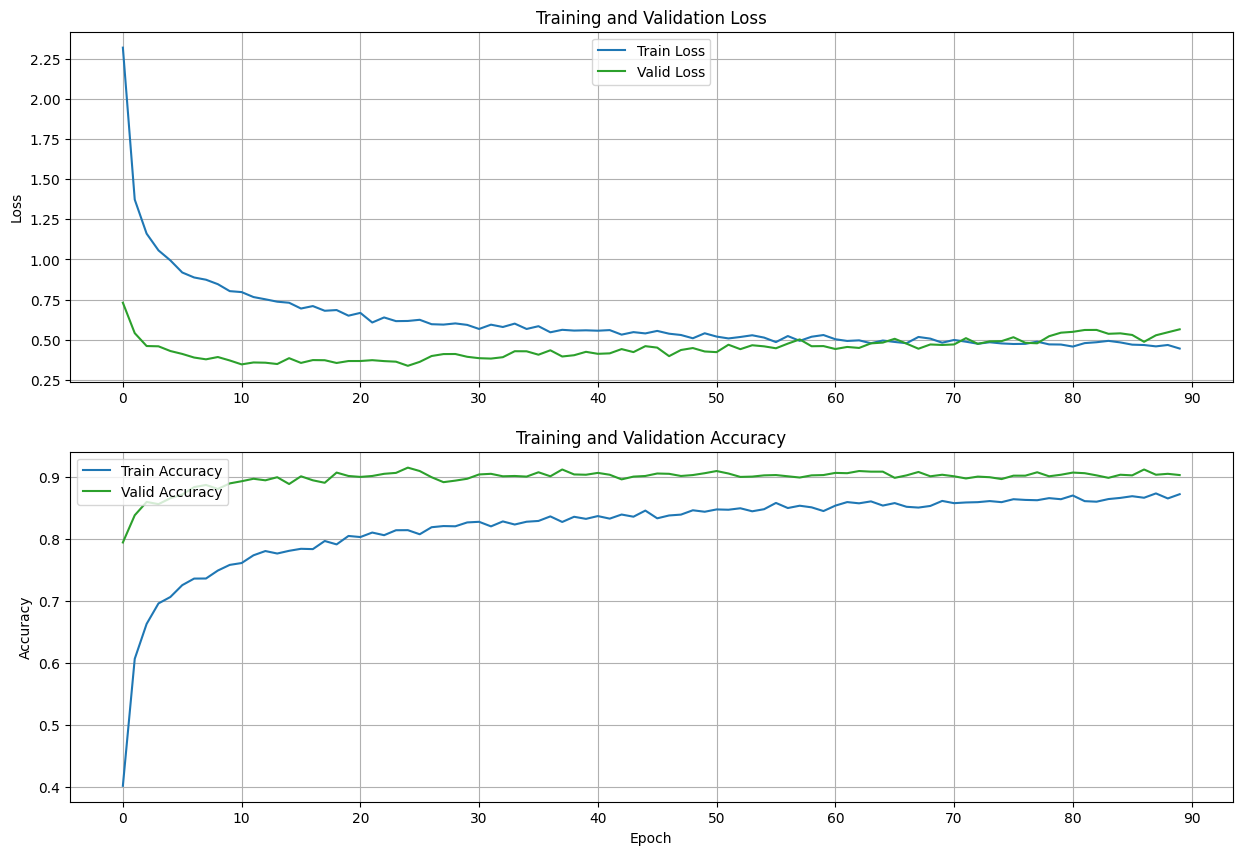

In [20]:
loss = training_results.history["loss"]
accuracy = training_results.history["accuracy"]

val_loss = training_results.history["val_loss"]
val_accuracy = training_results.history["val_accuracy"]

plot_history(
    train_loss=loss,
    train_metric=accuracy,
    val_loss=val_loss,
    val_metric=val_accuracy,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

In [22]:
def recreate_model(path, load_weights=False, config=DatasetConfig(), **kwargs):
    """
    For reloading a trained model.
    Args:
        path: current_version checkpoint path (either .ckpt for weights or .keras for full model)
        load_weights: Whether the files saved at path contains model weights
                      or the Entire model configuration
        **kwargs: use to pass additional keyword arguments to the load_model method
    Returns:
        Reinitialized Trained Model
    """

    if load_weights:
        # Create model architecture
        model = get_simplified_model(num_classes=config.NUM_CLASSES, input_shape=config.DATA_SHAPE)

        # Load trained model best weights.
        model.load_weights(path).expect_partial()
    else:
        # Load full model (if it’s a .keras file)
        model = tf.keras.models.load_model(path, **kwargs)

    model.summary()
    return model


In [23]:
load_version = current_version_name
checkpoint_path = "/kaggle/working/Logs_Checkpoints/Model_checkpoints/version_1/best_model.keras"

trained_model = recreate_model(checkpoint_path)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 73)             │        74,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,209,280 (31.32 MB)

 Trainable params: 1,386,569 (5.29 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 2,773,140 (10.58 MB)

In [24]:
def get_sample_predictions(*, model, dataset, total=15):

    imgs = []
    ground_truths = []
    probs = []
    predictions = []

    idx_to_cls = {0:'air_hockey', 1:'ampute_football', 2:'archery', 3:'arm_wrestling', 4:'balance_beam', 5:'barell_racing', 6:'baseball', 7:'basketball', 8:'billiards', 9:'bmx', 
              10:'bobsled', 11:'bowling', 12:'boxing', 13:'bull_riding', 14:'canoe_slamon', 15:'cricket', 16:'croquet', 17:'curling', 18:'fencing', 19:'field_hockey', 
              20:'figure_skating_men', 21:'figure_skating_pairs', 22:'figure_skating_women', 23:'football', 24:'formula_1_racing', 25:'frisbee', 26:'giant_slalom', 27:'golf', 
              28:'hammer_throw', 29:'harness_racing', 30:'high_jump', 31:'hockey', 32:'horse_jumping', 33:'horse_racing', 34:'hurdles', 35:'ice_climbing', 36:'jai_alai', 
              37:'javelin', 38:'judo', 39:'lacrosse', 40:'luge', 41:'motorcycle_racing', 42:'nascar_racing', 43:'olympic_wrestling', 44:'parallel_bar', 45:'pole_vault', 
              46:'polo', 47:'pommel_horse', 48:'rings', 49:'rock_climbing', 50:'rollerblade_racing', 51:'rowing', 52:'rugby', 53:'sailboat_racing', 54:'shot_put', 55:'ski_jumping', 
              56:'skydiving', 57:'snow_boarding', 58:'snowmobile_racing', 59:'speed_skating', 60:'sumo_wrestling', 61:'surfing', 62:'swimming', 63:'table_tennis', 64:'tennis', 
              65:'track_bicycle', 66:'tug_of_war', 67:'uneven_bars', 68:'volleyball', 69:'water_polo', 70:'weightlifting', 71:'wheelchair_basketball', 72:'wheelchair_racing'}
            


    print("Generating Predictions...")
    for data, target in dataset:
        model_predictions = model.predict_on_batch(data)
        cls_predicted = np.argmax(model_predictions, axis=-1)
        cls_probs = np.max(model_predictions, axis=-1)
    
        imgs.extend(data.numpy() / 255.)
        ground_truths.extend(target.numpy())
        predictions.extend(cls_predicted)
        probs.extend(cls_probs)
        
        # Displaying only 15 images 
        if data.shape[0] >= total: 
            break

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (18, 9)
    fig = plt.figure()
    fig.set_facecolor("white")

    for idx in range(total):

        plt.subplot(3, 5, idx + 1)
        img = imgs[idx]
        plt.imshow(img)

        plt.title(f"P:{idx_to_cls[predictions[idx]]}({probs[idx]:.2}), T:{idx_to_cls[ground_truths[idx]]}")
        plt.axis("off")

    fig.savefig("sample_predictions.png")
    plt.show(block=block_plot)
    
    del imgs, ground_truths, probs, predictions
    return

Found 2007 files belonging to 73 classes.
Generating Predictions...


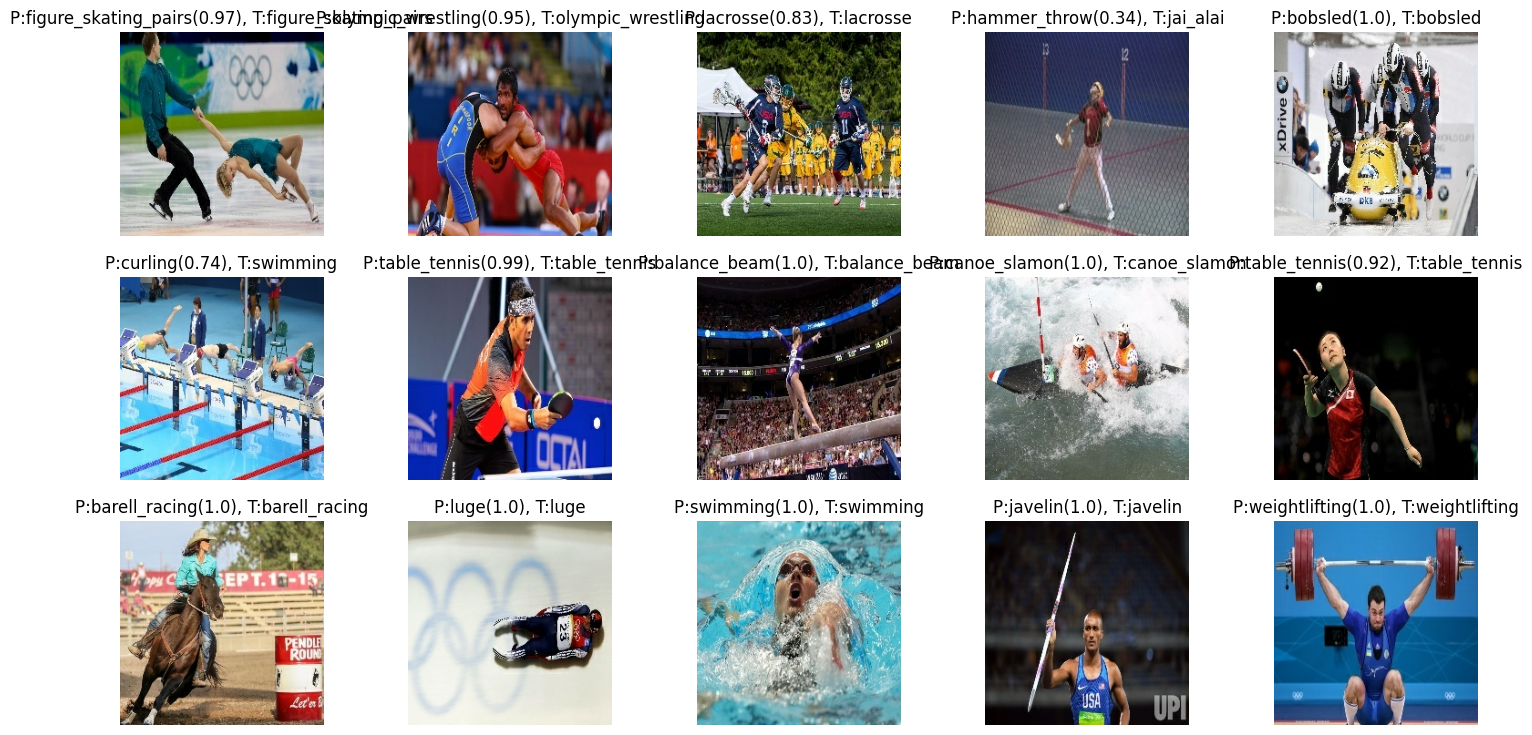

In [25]:
data_config = DatasetConfig()
training_config = TrainingConfig()

valid_path = os.path.join(data_config.DATA_ROOT, "valid")

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_path, 
    label_mode='int',
    color_mode='rgb', 
    batch_size=training_config.BATCH_SIZE, 
    image_size=data_config.DATA_SHAPE[:2], 
    shuffle=True, # shuffling to show images from all classes
)

get_sample_predictions(model=trained_model, dataset=valid_dataset)

## Generating csv

In [27]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming DatasetConfig and TrainingConfig are defined elsewhere and provide necessary paths and parameters
data_config = DatasetConfig()
training_config = TrainingConfig()

# Define the class labels
class_labels = ['air_hockey', 'ampute_football', 'archery', 'arm_wrestling', 'balance_beam', 'barell_racing', 'baseball', 
'basketball', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull_riding', 'canoe_slamon', 'cricket', 
'croquet', 'curling', 'fencing', 'field_hockey', 'figure_skating_men', 'figure_skating_pairs', 
'figure_skating_women', 'football', 'formula_1_racing', 'frisbee', 'giant_slalom', 'golf', 'hammer_throw', 
'harness_racing', 'high_jump', 'hockey', 'horse_jumping', 'horse_racing', 'hurdles', 'ice_climbing', 'jai_alai', 
'javelin', 'judo', 'lacrosse', 'luge', 'motorcycle_racing', 'nascar_racing', 'olympic_wrestling', 'parallel_bar', 
'pole_vault', 'polo', 'pommel_horse', 'rings', 'rock_climbing', 'rollerblade_racing', 'rowing', 'rugby', 
'sailboat_racing', 'shot_put', 'ski_jumping', 'skydiving', 'snow_boarding', 'snowmobile_racing', 'speed_skating', 
'sumo_wrestling', 'surfing', 'swimming', 'table_tennis', 'tennis', 'track_bicycle', 'tug_of_war', 'uneven_bars', 
'volleyball', 'water_polo', 'weightlifting', 'wheelchair_basketball', 'wheelchair_racing']


# Load the test.csv
test_df = pd.read_csv('/kaggle/input/open-cv-tf-project-2-image-classification-round-3/test.csv') 

# Define the path where your model is saved
load_version = current_version_name
checkpoint_path = "/kaggle/working/Logs_Checkpoints/Model_checkpoints/version_1/best_model.keras"

trained_model = recreate_model(checkpoint_path)

# Define the path to the test images
test_images_dir = '/kaggle/input/open-cv-tf-project-2-image-classification-round-3/sports_images/all_images'  

# Create a list to store predictions
predictions = []

# Iterate through the test images and make predictions
for index, row in test_df.iterrows():
    image_id = row['ID']
    image_path = os.path.join(test_images_dir, f'{image_id}')  # Assuming images are in .jpg format
    
    if os.path.exists(image_path):  # Check if the image file exists
        # Load and preprocess the image
        img = load_img(image_path, target_size=(data_config.DATA_SHAPE[0], data_config.DATA_SHAPE[1]))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make prediction
        preds = trained_model.predict(img_array)
        pred_class_index = np.argmax(preds, axis=1)[0]  # Get the predicted class index
        pred_class_name = class_labels[pred_class_index]  # Map index to class name
        
        # Append the prediction
        predictions.append((image_id, pred_class_name))
    else:
        print(f"Image {image_id} not found!")

# Create a DataFrame with predictions
predictions_df = pd.DataFrame(predictions, columns=['ID', 'CLASS'])

# Save to CSV
predictions_df.to_csv('/kaggle/working/submission.csv', index=False)

print("Predictions saved to /kaggle/working/submission.csv")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 73)             │        74,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,209,280 (31.32 MB)

 Trainable params: 1,386,569 (5.29 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 2,773,140 (10.58 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━